<a href="https://colab.research.google.com/github/hananbahtiti/Hybrid-Intrusion-detection-Systems/blob/main/Host_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -U gdown
!gdown --id 1D_hUX2bIlKal9Ym97z5p1i_JlFd0b0Zw -O /kaggle/working/data.csv


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1D_hUX2bIlKal9Ym97z5p1i_JlFd0b0Zw
From (redirected): https://drive.google.com/uc?id=1D_hUX2bIlKal9Ym97z5p1i_JlFd0b0Zw&confirm=t&uuid=3213747c-a5f8-4f8d-b542-2d80ae2fb9ff
To: /kaggle/working/data.csv
100%|█████████████████████████████████████████| 259M/259M [00:01<00:00, 142MB/s]


2025-05-03 11:46:43.199781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746272803.411041      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746272803.464885      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746272822.315921      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/100


I0000 00:00:1746272826.434849     100 service.cc:148] XLA service 0x7a44d8003bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746272826.435492     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746272826.612294     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


   129/450000 ━━━━━━━━━━━━━━━━━━━━ 8:54 1ms/step - loss: 1.2529  

I0000 00:00:1746272827.156742     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


449963/450000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066
Epoch 1: val_loss improved from inf to 0.00001, saving model to /kaggle/working/model/autoencoder_model.keras
450000/450000 ━━━━━━━━━━━━━━━━━━━━ 642s 1ms/step - loss: 0.0066 - val_loss: 1.1432e-05
Epoch 2/100
449975/450000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5929e-05
Epoch 2: val_loss did not improve from 0.00001
450000/450000 ━━━━━━━━━━━━━━━━━━━━ 635s 1ms/step - loss: 6.5929e-05 - val_loss: 2.4325e-04
Epoch 3/100
449960/450000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4879e-05
Epoch 3: val_loss improved from 0.00001 to 0.00000, saving model to /kaggle/working/model/autoencoder_model.keras
450000/450000 ━━━━━━━━━━━━━━━━━━━━ 653s 1ms/step - loss: 4.4879e-05 - val_loss: 4.9440e-06
Epoch 4/100
449998/450000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9453e-05
Epoch 4: val_loss did not improve from 0.00000
450000/450000 ━━━━━━━━━━━━━━━━━━━━ 662s 1ms/step - loss: 3.9453e-05 - val_loss: 1.5778e-05
Epoch 5/100
449973/450000 

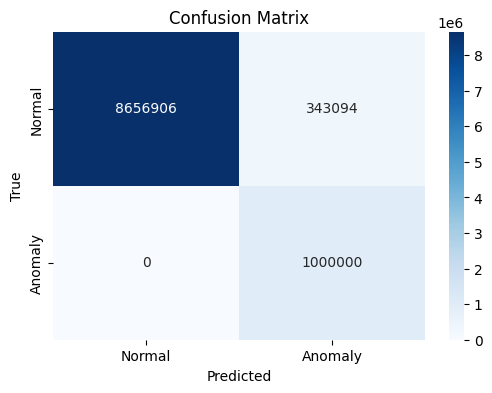

[✓] Loss plot saved to: /kaggle/working/model/training_loss.png


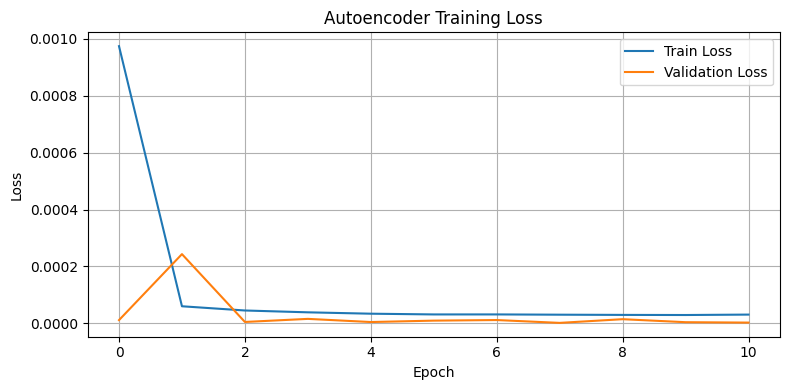

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[✓] Error distribution plot saved to: /kaggle/working/model/reconstruction_error_distribution.png


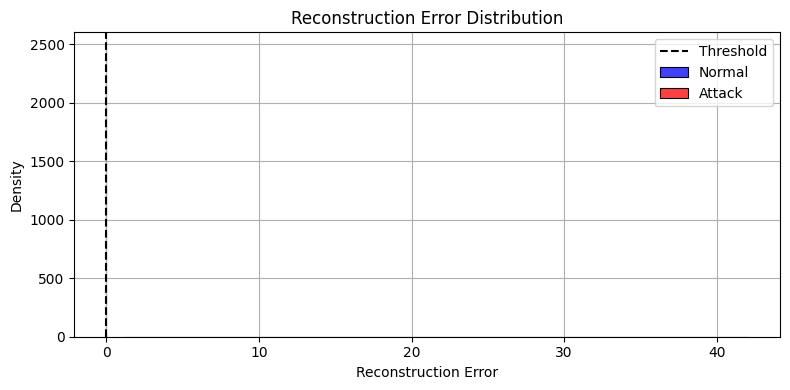

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.get_logger().setLevel('ERROR')

# ========== SETTINGS ==========
DATA_PATH = '/kaggle/working/data.csv'  # Input CSV
OUTPUT_CSV = '/kaggle/working/model/anomaly_detection_results.csv'
MODEL_PATH = '/kaggle/working/model/autoencoder_model.keras'
PLOT_DIR = '/kaggle/working/model/'
os.makedirs(PLOT_DIR, exist_ok=True)

# ========== LOAD & PREPARE DATA ==========
data = pd.read_csv(DATA_PATH)
X = data.drop(columns=['Label'])
y = data['Label']

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use only normal samples to train the autoencoder
X_normal = X_scaled[y == 0]
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

# ========== AUTOENCODER MODEL ==========
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)
"""
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)"""

decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', verbose=1)

# ========== TRAINING ==========
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, X_val),
    shuffle=True,
    verbose=1,
    callbacks=[early_stop, model_checkpoint]
)

print(f"[✓] Model saved to: {MODEL_PATH}")

# ========== PREDICTION ==========
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_pred - X_scaled, 2), axis=1)
#threshold = mse[y == 0].max()
threshold = np.percentile(mse[y == 0], 95)

# Predict anomalies
predictions = (mse > threshold).astype(int)


# Save predictions
output_df = data.copy()
output_df['reconstruction_error'] = mse
output_df['predicted'] = predictions
output_df.to_csv(OUTPUT_CSV, index=False)
print(f"[✓] Predictions saved to: {OUTPUT_CSV}")

# ========== METRICS ==========
y_true = y.values
auc = roc_auc_score(y_true, mse)
f1 = f1_score(y_true, predictions)


print(f"AUC Score: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, predictions))

# ========== CONFUSION MATRIX HEATMAP ==========
conf_mat = confusion_matrix(y_true, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
conf_path = os.path.join(PLOT_DIR, 'confusion_matrix.png')
plt.savefig(conf_path)
print(f"[✓] Confusion matrix plot saved to: {conf_path}")
plt.show()
plt.close()

# ========== PLOT TRAINING LOSS ==========
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
loss_path = os.path.join(PLOT_DIR, 'training_loss.png')
plt.savefig(loss_path)
print(f"[✓] Loss plot saved to: {loss_path}")
plt.show()
plt.close()

# ========== PLOT RECONSTRUCTION ERROR DISTRIBUTION ==========
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_label': y_true})
plt.figure(figsize=(8, 4))
sns.histplot(error_df[error_df['true_label'] == 0]['reconstruction_error'], bins=50, color='blue', label='Normal', stat='density')
sns.histplot(error_df[error_df['true_label'] == 1]['reconstruction_error'], bins=50, color='red', label='Attack', stat='density')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
error_path = os.path.join(PLOT_DIR, 'reconstruction_error_distribution.png')
plt.savefig(error_path)
print(f"[✓] Error distribution plot saved to: {error_path}")
plt.show()
plt.close()


[✓] ROC curve plot saved to: /kaggle/working/model/roc_curve.png


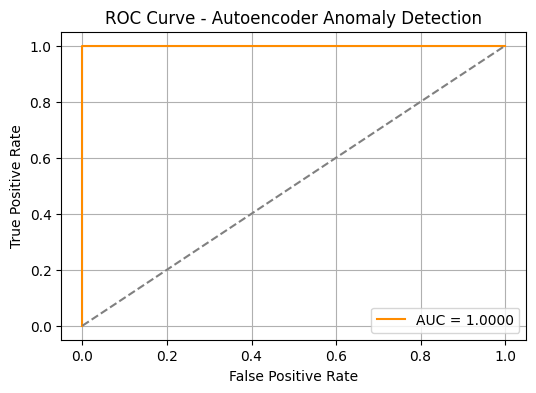

In [ ]:
from sklearn.metrics import roc_curve

# حساب القيم لرسم منحنى ROC
fpr, tpr, thresholds = roc_curve(y_true, mse)

# رسم المنحنى
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Autoencoder Anomaly Detection')
plt.legend(loc='lower right')
plt.grid(True)

roc_path = os.path.join(PLOT_DIR, 'roc_curve.png')
plt.savefig(roc_path)
print(f"[✓] ROC curve plot saved to: {roc_path}")
plt.show()
plt.close()
